In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, shapiro, ttest_rel

import msastats
from spartaabc.abc_inference import load_data, load_correction_regressors, load_correction_regressor_scores, bias_correction
from spartaabc.abc_inference import IndelParams

from spartaabc.utility import get_msa_path, PARAMS_LIST


In [ ]:
distance_metric = "mahal"
top_cutoff = 1000
aligner = "mafft"
bats_path = Path("bat_msas").resolve()
others_path = Path("other_msas").resolve()

datasets = [data.stem for data in bats_path.iterdir()]


print(datasets)

['374286_NT_AL_AA', '91828_NT_AL_AA', '84310_NT_AL_AA', '23645_NT_AL_AA', '1834_NT_AL_AA', '375449_NT_AL_AA', '9719_NT_AL_AA', '402381_NT_AL_AA', '57670_NT_AL_AA', '374920_NT_AL_AA', '3909_NT_AL_AA', '286464_NT_AL_AA', '1258_NT_AL_AA', '9858_NT_AL_AA', '23072_NT_AL_AA', '80164_NT_AL_AA', '923_NT_AL_AA', '9612_NT_AL_AA', '2580_NT_AL_AA', '199720_NT_AL_AA', '777_NT_AL_AA', '84643_NT_AL_AA', '388015_NT_AL_AA', '401934_NT_AL_AA', '7455_NT_AL_AA', '7038_NT_AL_AA', '23359_NT_AL_AA', '54456_NT_AL_AA', '51112_NT_AL_AA', '26230_NT_AL_AA', '80022_NT_AL_AA', '375686_NT_AL_AA', '11093_NT_AL_AA', '23308_NT_AL_AA', '375759_NT_AL_AA', '55778_NT_AL_AA', '53820_NT_AL_AA', '261734_NT_AL_AA', '114780_NT_AL_AA', '57481_NT_AL_AA', '8871_NT_AL_AA', '176_NT_AL_AA', '57538_NT_AL_AA', '283638_NT_AL_AA', '27445_NT_AL_AA', '7288_NT_AL_AA', '151176_NT_AL_AA', '196385_NT_AL_AA', '387509_NT_AL_AA', '55036_NT_AL_AA', '284297_NT_AL_AA']


In [3]:
def get_top_params(main_path: Path):
    MSA_PATH = get_msa_path(main_path)

    empirical_stats = msastats.calculate_fasta_stats(MSA_PATH)

    stats_data = load_data(main_path)
    regressors = load_correction_regressors(main_path, aligner)
    regressor_scores = load_correction_regressor_scores(main_path, aligner)

    params_data = []
    full_stats_data = []
    for model in  stats_data.keys():
        current_regressors = regressors.get(model, None)
        params_data.append(stats_data[model][PARAMS_LIST])

        if current_regressors is not None:
            temp_df, kept_statistics = bias_correction(current_regressors, stats_data[model], regressor_scores)
            full_stats_data.append(temp_df)

    empirical_stats = [empirical_stats[i] for i in kept_statistics]

    params_data = pd.concat(params_data)
    full_stats_data = pd.concat(full_stats_data)

    calculated_distances = None

    if distance_metric == "mahal":
        cov = np.cov(full_stats_data.T)
        cov = cov + np.eye(len(cov))*1e-4
        inv_covmat = np.linalg.inv(cov)
        u_minus_v = empirical_stats-full_stats_data
        left = np.dot(u_minus_v, inv_covmat)
        calculated_distances = np.sqrt(np.sum(u_minus_v*left, axis=1))
    if distance_metric == "euclid":
        weights = 1/(full_stats_data.std(axis=0) + 0.001)
        calculated_distances = np.sum(weights*(full_stats_data - empirical_stats)**2, axis=1)

    full_stats_data["distances"] = calculated_distances
    full_stats_data[PARAMS_LIST] = params_data

    top_stats = full_stats_data.nsmallest(top_cutoff, "distances")
    return top_stats

In [4]:
top_params = {}
valid_datasets = []
for dataset in datasets:
    # (dir / "alignment.fasta.raxml.bestModel")
    try:
        top_params[dataset] = (get_top_params(bats_path/ dataset),
                               get_top_params(others_path / dataset))
        valid_datasets.append(dataset)
    except Exception as e:
        print(dataset, e)
        continue

375449_NT_AL_AA local variable 'kept_statistics' referenced before assignment
3909_NT_AL_AA local variable 'kept_statistics' referenced before assignment
286464_NT_AL_AA local variable 'kept_statistics' referenced before assignment
7455_NT_AL_AA local variable 'kept_statistics' referenced before assignment
7038_NT_AL_AA local variable 'kept_statistics' referenced before assignment
80022_NT_AL_AA local variable 'kept_statistics' referenced before assignment
114780_NT_AL_AA local variable 'kept_statistics' referenced before assignment
176_NT_AL_AA local variable 'kept_statistics' referenced before assignment
27445_NT_AL_AA local variable 'kept_statistics' referenced before assignment
196385_NT_AL_AA local variable 'kept_statistics' referenced before assignment


In [5]:
def get_missing_indel_model(data_path: Path,full_stats_data: pd.DataFrame):
    top_stats = full_stats_data.nsmallest(100, "distances")
    abc_indel_params = None
    if len(top_stats[top_stats["insertion_rate"] == top_stats["deletion_rate"]]) > (top_cutoff // 2):
        full_sim_data = full_stats_data[full_stats_data["insertion_rate"] == full_stats_data["deletion_rate"]]
        top_sim_data = full_sim_data.nsmallest(top_cutoff, "distances")
        root_length = int(top_sim_data["root_length"].mean())
        R_ID = float(top_sim_data["insertion_rate"].mean())
        A_ID = float(top_sim_data["length_param_insertion"].mean())
        abc_indel_params = IndelParams(root_length,
                                       R_ID, R_ID,
                                       A_ID, A_ID,
                                       length_distribution="zipf",
                                       indel_model="SIM")
    else:
        full_rim_data = full_stats_data[full_stats_data["insertion_rate"] != full_stats_data["deletion_rate"]]
        top_rim_data = full_rim_data.nsmallest(top_cutoff, "distances")
        root_length = int(top_rim_data["root_length"].mean())
        R_I = float(top_rim_data["insertion_rate"].mean())
        R_D = float(top_rim_data["deletion_rate"].mean())
        A_I = float(top_rim_data["length_param_insertion"].mean())
        A_D = float(top_rim_data["length_param_deletion"].mean())
        abc_indel_params = IndelParams(root_length,
                                       R_I, R_D,
                                       A_I, A_D,
                                       length_distribution="zipf",
                                       indel_model="RIM")
    return abc_indel_params


In [6]:
indel_models = {}
for dataset in valid_datasets:
    # (dir / "alignment.fasta.raxml.bestModel")
    # try:
    indel_models[dataset] = (get_missing_indel_model(bats_path / dataset, top_params[dataset][0]),
                              get_missing_indel_model(others_path / dataset, top_params[dataset][1]))
    # except Exception as e:
    #     print(e)
    #     continue

In [7]:
data_comparison = {"dataset": [], 
                   "insertion_bats": [], "insertion_others": [],
                   "deletion_bats": [], "deletion_others": [],
                   "length_insertion_bats": [], "length_insertion_others": [],
                   "length_deletion_bats": [], "length_deletion_others": []}
for dataset in valid_datasets:
    data_comparison["dataset"].append(dataset)
    data_comparison["insertion_bats"].append(indel_models[dataset][0].insertion_rate)
    data_comparison["deletion_bats"].append(indel_models[dataset][0].deletion_rate)
    data_comparison["length_insertion_bats"].append(indel_models[dataset][0].insertion_length_parameter)
    data_comparison["length_deletion_bats"].append(indel_models[dataset][0].deletion_length_parameter)
    data_comparison["insertion_others"].append(indel_models[dataset][1].insertion_rate)
    data_comparison["deletion_others"].append(indel_models[dataset][1].deletion_rate)
    data_comparison["length_insertion_others"].append(indel_models[dataset][1].insertion_length_parameter)
    data_comparison["length_deletion_others"].append(indel_models[dataset][1].deletion_length_parameter)

In [8]:
comparison_df = pd.DataFrame(data_comparison)

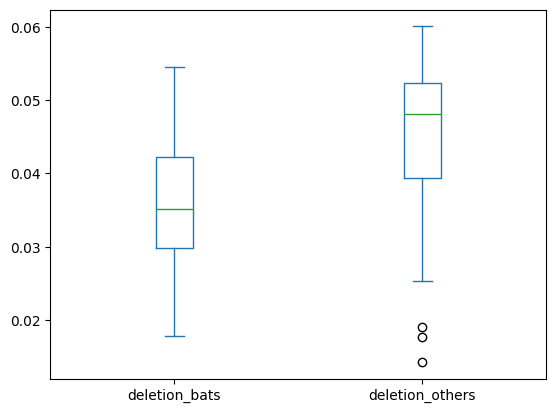

In [18]:
ax = comparison_df[["deletion_bats", "deletion_others"]].plot.box()
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.1)
# ax.axline((0, 0), slope=1)

In [19]:
shapiro(comparison_df["insertion_others"]), shapiro(comparison_df["insertion_bats"])

(ShapiroResult(statistic=np.float64(0.940848361751595), pvalue=np.float64(0.03361124963259325)),
 ShapiroResult(statistic=np.float64(0.968936873124303), pvalue=np.float64(0.31820117916964863)))

In [20]:
ttest_rel(comparison_df["insertion_bats"], comparison_df["insertion_others"])

TtestResult(statistic=np.float64(-2.5315056110337157), pvalue=np.float64(0.015390271352138288), df=np.int64(40))

In [21]:
ttest_rel(comparison_df["deletion_bats"], comparison_df["deletion_others"])

TtestResult(statistic=np.float64(-3.685887470361784), pvalue=np.float64(0.0006758760667445881), df=np.int64(40))

In [22]:
ttest_rel(comparison_df["length_insertion_bats"], comparison_df["length_insertion_others"])

TtestResult(statistic=np.float64(-4.187157172113105), pvalue=np.float64(0.0001506886496122146), df=np.int64(40))

In [23]:
ttest_rel(comparison_df["length_deletion_bats"], comparison_df["length_deletion_others"])

TtestResult(statistic=np.float64(4.8777607874344175), pvalue=np.float64(1.7465630450422177e-05), df=np.int64(40))

In [59]:
comparison_df.describe()

,insertion_bats,insertion_others,deletion_bats,deletion_others,length_insertion_bats,length_insertion_others,length_deletion_bats,length_deletion_others
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.012544,0.014363,0.036016,0.044215,1.995234,2.052246,1.405270,1.319578
std,0.002667,0.003453,0.008902,0.011903,0.067421,0.071036,0.091961,0.063849
min,0.007913,0.006420,0.017791,0.014254,1.671665,1.920637,1.242262,1.238350
25%,0.010941,0.012628,0.029784,0.039408,1.978288,2.017794,1.339994,1.278991
50%,0.012550,0.014892,0.035203,0.048122,2.011831,2.044323,1.406929,1.308553
75%,0.014063,0.016734,0.042305,0.052275,2.036144,2.095591,1.445731,1.350590
max,0.020688,0.023682,0.054573,0.060058,2.072306,2.235246,1.657649,1.581674
